# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year}.tsv``, ``positive_validation_x_years_after_{year}.tsv``, ``negative_prediction_x_years_after_{year}.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

In [2]:
target_year = 2018
num_years_later = 1

## Input files
``embedding_SG_dim100_upto{year}.npy`` is the result of word2vec embedding of pubmed. ``words_SG_upto{}.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 278138 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2018.npy and ../data/embeddings_final/words_SG_upto2018.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,5.544086,3.900244,-5.571107,4.023921,-0.690671,5.045084,2.891233,5.713561,-3.167775,-5.355447,...,-1.178944,4.227701,-2.802720,-2.910172,-6.635629,1.170757,-3.134710,4.245651,1.295776,9.294687
patient,5.516126,4.064995,-7.371462,3.275807,-0.869867,5.350581,1.613561,5.720035,-2.368225,-5.069319,...,-0.528910,6.041771,-1.382483,-3.134443,-5.441506,1.143770,-3.800462,3.609437,1.312677,7.749951
meshd009369,5.514330,5.347095,-4.511601,4.540993,-0.171103,5.186315,1.921842,4.063017,-1.242869,-6.585094,...,-1.102929,3.709254,-3.064297,-1.693331,-4.602835,1.124388,-4.023498,5.386783,0.727251,8.287968
0,3.015314,4.347253,-5.247945,1.300399,-0.455834,6.122954,2.457049,5.309476,-3.489525,-6.540120,...,-0.589856,5.145733,-1.263917,-2.682243,-5.214277,1.378899,-4.782578,3.532945,1.179421,7.920753
study,5.344758,5.892451,-5.636815,2.876613,-0.623532,5.338674,2.060991,5.173227,-2.785678,-3.045907,...,-0.630316,3.953412,-1.198569,-2.071625,-4.895279,1.073490,-2.490999,3.854250,0.936672,7.703007
1,3.740305,4.762334,-5.183757,1.510455,-0.324129,5.206121,1.944532,4.878118,-3.192989,-4.791201,...,-0.950221,5.208447,-2.343183,-2.127656,-5.012542,1.198391,-3.963571,3.774423,1.682876,8.378260
use,3.858829,5.224904,-5.747828,2.767147,-0.708477,5.809757,2.388821,4.325610,-3.059532,-4.986820,...,-0.618118,2.951320,-1.668634,-5.023390,-3.281270,1.128616,-4.117539,3.972474,0.927381,7.407399
treatment,4.320082,3.552744,-4.864308,3.393475,-0.724211,5.659916,1.947094,7.243562,-2.682269,-6.335474,...,-0.241835,4.782804,-1.093247,-3.258259,-4.739478,1.255569,-3.629974,4.610537,1.030638,9.041243
2,3.333377,4.558437,-5.366470,1.589037,-0.440878,5.951880,1.651716,5.093137,-3.016540,-5.232817,...,-0.936136,5.502128,-2.022234,-2.331195,-4.670235,1.276601,-3.627492,3.394002,1.605149,8.407037
expression,3.801692,4.275945,-5.162064,3.334162,-0.515905,6.005465,3.258746,6.466090,-2.133804,-4.737078,...,-1.461477,6.418555,-1.717424,-3.600635,-4.764203,1.493333,-4.182888,3.568821,0.907861,8.706170


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  278138


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd002289,ncbigene1956
1,meshd002289,ncbigene2064
2,meshd002289,ncbigene2066
3,meshd002294,ncbigene1956
4,meshd002294,ncbigene2064


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

465 positive examples
278138 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 381 kinase-cancer difference vectors
[INFO]	Initial data: 465 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 1 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,-3.239107,0.245929,0.773560,-0.640676,-0.338023,2.571537,-0.563340,-0.889164,-0.138696,-1.561695,...,0.417250,-2.413453,-1.180655,1.232238,-1.317104,0.139265,-0.744309,-0.338702,1.198285,0.441039
ncbigene2064-meshd002289,-2.644751,1.072389,2.272508,-0.638248,-0.582121,2.391233,-0.514758,-1.444349,-0.777111,-0.603968,...,0.177549,-2.599428,-1.195050,1.754695,-0.067019,-0.032097,-1.102636,-0.208887,1.208584,0.368526
ncbigene2066-meshd002289,-2.854317,1.005730,2.450376,-1.697786,-0.335900,1.708226,-0.735822,-1.554486,0.694125,-0.592814,...,0.812708,-2.721399,-0.857599,0.350145,0.330992,0.366557,0.333867,-1.765329,1.707907,-0.539112
ncbigene1956-meshd002294,-1.568446,-0.135508,0.370564,-0.160120,-0.438520,-0.734251,-0.426531,-1.338006,-1.577734,-0.632871,...,-0.208203,-0.976566,0.474222,3.569532,-1.439013,0.573701,-0.006658,2.071012,0.058532,-0.190969
ncbigene2064-meshd002294,-0.974090,0.690951,1.869513,-0.157692,-0.682618,-0.914555,-0.377949,-1.893190,-2.216149,0.324855,...,-0.447903,-1.162541,0.459828,4.091989,-0.188928,0.402338,-0.364985,2.200826,0.068831,-0.263482


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

381 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd015529,ncbigene1111
1,meshd010145,ncbigene11011
2,meshd018282,ncbigene23617
3,meshd018220,ncbigene22848
4,meshd012207,ncbigene3656


In [12]:
print("%d negative examples" % len(negative_df))

3870 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 3455 kinase-cancer difference vectors
[INFO]	Initial data: 3870 examples
[INFO]	Could not identify 19 gene ids
[INFO]	Could not identify 49 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1111-meshd015529,1.392524,-1.455263,-0.704912,0.160040,-1.095659,-1.389516,0.436832,-0.139903,-1.403400,-1.868400,...,1.671824,0.999490,-1.235959,-0.157894,-0.903618,0.430109,-0.883297,0.427422,-0.774987,2.085782
ncbigene11011-meshd010145,-0.512490,-0.081195,-0.023294,-0.265349,-0.595491,0.090668,-0.013730,0.003477,0.325401,0.289312,...,0.275879,-0.617751,-0.136204,-0.191604,0.785217,-0.944975,0.013373,-0.519633,-0.307462,-0.145311
ncbigene23617-meshd018282,-0.981023,-2.108676,2.762367,-1.659498,-0.472591,-3.059467,-0.320023,-2.194665,0.158092,1.645340,...,0.606809,-2.049353,-0.774042,0.749053,2.629078,-1.542803,1.057030,-2.494394,-1.179027,-2.141940
ncbigene22848-meshd018220,-0.637043,-1.384164,1.831336,-2.296619,-0.105409,-2.359558,-0.811809,-1.218028,0.370229,2.484728,...,-0.125326,-1.526411,-0.073561,1.731743,2.756058,-1.624507,1.629572,-1.960672,-1.073498,-1.655683
ncbigene3656-meshd012207,-0.488385,0.051739,0.815605,-1.938539,0.087804,-1.144618,0.674634,-0.562492,-0.040970,1.534455,...,1.342593,-0.829684,0.533237,1.707665,1.256722,-1.216892,-0.278405,-0.634643,-1.283388,-0.096597


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=381) and negative (n=3455) to the combined dataframe (3836)


In [16]:
X_train.values

array([[-3.239107  ,  0.24592948,  0.7735596 , ..., -0.33870173,
         1.1982846 ,  0.4410391 ],
       [-2.6447506 ,  1.0723889 ,  2.2725081 , ..., -0.2088871 ,
         1.2085836 ,  0.36852598],
       [-2.8543174 ,  1.0057304 ,  2.450376  , ..., -1.7653294 ,
         1.7079072 , -0.5391116 ],
       ...,
       [ 0.6170008 , -0.72214246, -0.867975  , ..., -0.26667142,
        -1.859388  ,  0.358912  ],
       [ 0.13779163,  0.34713745,  0.19402742, ..., -0.88145137,
        -0.60538375, -0.28954792],
       [ 3.4183078 ,  1.1494751 , -4.1039443 , ...,  1.6742989 ,
         0.6069215 ,  4.1813684 ]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6555216  0.04084686 0.03239689]


Text(0, 0.5, 'PC 2 (4.08%)')

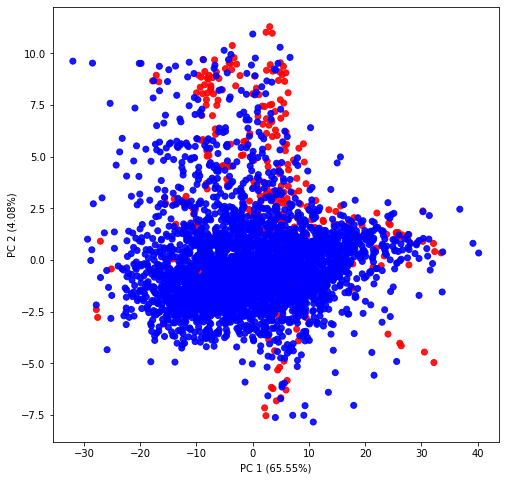

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3836 samples in 0.002s...
[t-SNE] Computed neighbors for 3836 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3836
[t-SNE] Computed conditional probabilities for sample 2000 / 3836
[t-SNE] Computed conditional probabilities for sample 3000 / 3836
[t-SNE] Computed conditional probabilities for sample 3836 / 3836
[t-SNE] Mean sigma: 0.889631
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.534920
[t-SNE] KL divergence after 300 iterations: 1.392319
t-SNE done! Time elapsed: 8.157339811325073 seconds


Text(0, 0.5, 'tsne-2d-two')

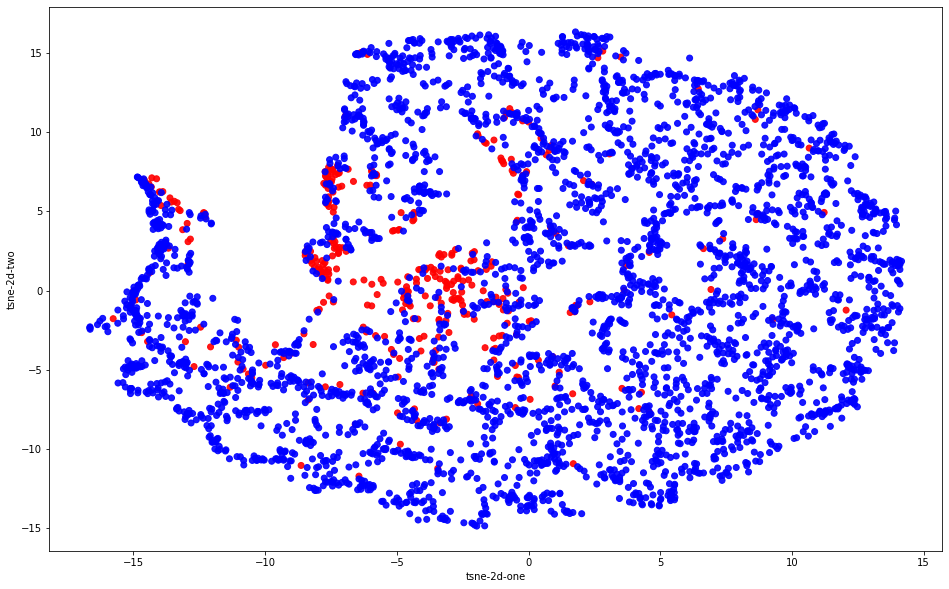

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (3836, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 381, number of negative examples: 3455, Y_train.shape: (3836,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd005770,ncbigene4233
1,meshd008258,ncbigene5290
2,meshd002583,ncbigene25
3,meshd018275,ncbigene10461
4,meshd016609,ncbigene5605


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 151 kinase-cancer difference vectors
[INFO]	Initial data: 158 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 4 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene4233-meshd005770,2.132254,2.664135,-3.133070,2.505516,-0.406174,3.775162,1.811508,2.334167,-0.098506,-3.651875,...,-0.277489,2.154577,0.058849,-0.238914,-3.064261,0.866360,-2.433633,3.442096,0.653168,4.939353
ncbigene5290-meshd008258,-1.049412,0.314024,0.031908,0.162663,0.442520,0.367448,-0.032968,-2.147178,-1.151194,-3.848777,...,-0.796779,0.886136,0.175259,2.989341,-0.242734,0.179595,-1.845254,0.777169,-0.868266,0.521793
ncbigene25-meshd002583,-0.927979,-1.055679,0.804346,1.136343,-1.125110,-2.959542,0.151753,-0.148486,-0.110820,-0.956655,...,1.776291,1.527981,0.581006,-0.958305,-1.793640,0.072398,0.262664,0.658522,1.360092,-0.326248
ncbigene10461-meshd018275,-0.088336,0.588838,0.330392,-0.768607,-0.408033,-1.192990,0.001427,-0.501365,0.616207,1.894985,...,0.467706,-0.509560,-1.160965,-0.458161,0.519251,-0.368326,1.093939,-0.884990,-1.057066,-0.607305
ncbigene5605-meshd016609,-1.274788,0.759874,0.361366,0.325792,-0.261517,0.236715,0.579682,-1.794025,-1.370500,0.125690,...,0.571535,-1.369588,1.660954,0.808305,0.161356,0.158687,-0.137765,0.842062,0.142172,1.219078


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd015472,ncbigene5347
1,meshd014402,ncbigene5586
2,meshd000236,ncbigene5163
3,meshd005185,ncbigene284086
4,meshd018226,ncbigene57551


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 3491 kinase-cancer difference vectors
[INFO]	Initial data: 3870 examples
[INFO]	Could not identify 19 gene ids
[INFO]	Could not identify 49 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene5586-meshd014402,-2.814628,-0.249446,0.537538,-3.039442,-0.371192,-1.453469,-0.196905,0.081796,0.252286,1.941775,...,1.639977,-0.704085,0.800388,0.128907,0.811920,-1.075230,0.553874,-0.469888,-1.440224,-0.679776
ncbigene5163-meshd000236,-0.018624,-1.767783,-0.418379,-0.720394,-1.142928,-3.176425,0.385144,-1.269683,-0.094249,1.836902,...,-0.228024,-0.839927,0.299476,-0.686138,0.963648,0.879625,1.171181,1.464335,-1.182718,-0.424929
ncbigene284086-meshd005185,-0.835727,-1.354343,1.589431,-1.066277,-0.483489,-2.181965,-0.081498,-0.907375,1.647691,0.643888,...,1.559224,-1.597228,0.261078,0.693579,2.188406,-1.713797,1.361260,-1.920625,-0.957206,-0.699672
ncbigene57551-meshd018226,-2.104143,-1.035168,0.546948,-2.546984,0.120509,-2.705281,-0.487339,-0.294227,1.693974,3.730154,...,0.540590,-0.444978,-0.062602,0.326364,1.795394,-1.501927,2.322047,-1.509118,-1.732293,-1.739017
ncbigene6714-meshd014134,-0.187495,0.266087,-2.477368,1.031161,-1.079688,0.269567,1.204836,0.194922,-0.016863,-0.674909,...,0.563458,1.615926,-0.581531,0.418010,-1.955451,0.463705,-0.660272,2.334940,0.060517,3.326228


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path ="positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)